## Libs and supplement functions

In [28]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
from librosa import display
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import HTML, Audio, display_html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [29]:
data_folder = 'C:/Users/Ivan_Hladkyi/Desktop/Audio_Classification/silero-audio-classifier' # change this to your path

In [30]:
def read_audio(path):
    sr, wav = read(path)
    assert sr == 16000
    assert len(wav) == 16000 * 3
    assert len(wav.shape) == 1
    return wav


def read_audio_norm(path):
    wav = read_audio(path)
    abs_max = np.abs(wav).max()
    wav = wav.astype('float32')
    if abs_max > 0:
        wav *= 1 / abs_max
    return wav


def audio_player(audio_path):
    return f'<audio preload="none" controls="controls"><source src="{audio_path}" type="audio/wav"></audio>'


## Read and validate the data

In [31]:
train_df = pd.read_csv(data_folder + '/train.csv')

## Read a random file

In [32]:
wav = read_audio(data_folder + '/train/' + train_df.sample(n=1).iloc[0].wav_path)
Audio(wav, rate=16000, autoplay=True)

## Extracting Mel Spectrograms

In [33]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

def spec_to_image(spec, eps=1e-6, is_255=False):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
    if is_255:
        spec_scaled *= 255
        spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

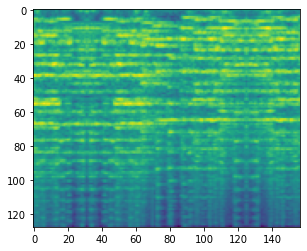

In [38]:
sample = train_df.sample(n=1).iloc[0].wav_path

img = spec_to_image(get_melspectrogram_db(data_folder + '/train/' + sample))
plt.imshow(img)

wav = read_audio(data_folder + '/train/' + sample)
Audio(wav, rate=16000, autoplay=True)

In [ ]:
limiter = int(train_df.shape[0] * 0.1) # take only 10% of training data

X = []
y = train_df.iloc[:limiter, 2].tolist()

# Iterate through each sound file and extract the features 
for index, row in train_df.iloc[:limiter].iterrows():
    file_name = data_folder + '/train/' + row['wav_path']
    data = spec_to_image(get_melspectrogram_db(file_name))[np.newaxis,...]
    X.append(data)
    
    if (index + 1) % 1000 == 0:
        print(f"{index + 1} files were processed")

X = np.array(X)

In [ ]:
# saving numpy arrays
# np.save(data_folder + '/numpy_CNN/train_y.npy', y)
# np.save(data_folder + '/numpy_CNN/train_X.npy', X)

# loading numpy arrays
y = np.load(data_folder + '/numpy_CNN/train_y.npy')
X = np.load(data_folder + '/numpy_CNN/train_X.npy')

In [ ]:
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 127)

In [ ]:
print(x_train.shape)
print(y_train.shape)

## Training

In [ ]:
X_train = torch.from_numpy(x_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).long())
X_test = torch.from_numpy(x_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).long())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
trainset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        self.drop_out = nn.Dropout(0.4)
        self.fc1 = nn.Linear(38912, 128)
        self.fc2 = nn.Linear(128, 3)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    
net = Net()

if torch.cuda.is_available():
    device=torch.device('cuda:0')
    net = net.to(device)
else:
    device=torch.device('cpu')


In [ ]:
from tqdm import tqdm


def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer


def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None, device_on=True):
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]

        if change_lr:
            optimizer = change_lr(optimizer, epoch)

        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            if device_on:
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []

        for i, data in enumerate(valid_loader):
            x, y = data
            if device_on:
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            if device_on:
                trace_y.append(y.cpu().detach().numpy())
                trace_yhat.append(y_hat.cpu().detach().numpy())
            else:
                trace_y.append(y.detach().numpy())
                trace_yhat.append(y_hat.detach().numpy())
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [ ]:
learning_rate = 2e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
net_train_losses=[]
net_valid_losses=[]

In [ ]:
train(net, loss_fn, trainloader, testloader, epochs, optimizer, net_train_losses, net_valid_losses, lr_decay, False)

In [ ]:
torch.save(net, 'AudioNet.pth')

## Creating a submission

In [ ]:
sample_submission = pd.read_csv(data_folder + '/sample_submission.csv')

In [ ]:
sample_submission.head()

In [ ]:
X = []

# Iterate through each sound file and extract the features 
for index, row in sample_submission.iterrows():
    file_name = data_folder + '/val/' + row['wav_path']
    data = spec_to_image(get_melspectrogram_db(file_name))[np.newaxis,...]
    X.append(data)
    
    if (index + 1) % 1000 == 0:
        print(f"{index + 1} files were processed")

X = np.array(X)

In [ ]:
# saving numpy arrays
# np.save(data_folder + '/numpy_CNN/val_X.npy', X)

# loading numpy arrays
X = np.load(data_folder + '/numpy_CNN/val_X.npy')

In [ ]:
X_val = torch.from_numpy(X).float()
print(X_val.shape)

In [ ]:
valset = torch.utils.data.TensorDataset(X_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=False)

In [ ]:
preds = []
batch_ind = 0

for data in valloader:
    if batch_ind % 100 == 0:
        print(f"Batch {batch_ind}...")
    y_pred = net(data[0])
    preds.append(np.argmax(y_pred.detach().numpy(), axis=1))
    batch_ind += 1
    
preds = np.concatenate(preds)

In [ ]:
preds[:20]

In [ ]:
submission = pd.DataFrame({'wav_path' : sample_submission['wav_path'], 'target': preds.tolist()})
submission.to_csv(data_folder + '/submission_CNN.csv', index=False)